* Probabilistic Relational Classifier
* Iterative Classification
* Correct and Smooth

In [3]:
import random
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)

seed_everything(42)

In [8]:
#probabilistic Relational Classifier
class ProbabilisticRelationalClassifier:
  def __init__(self, max_iter=10, threshold=0.01, node_size=2500, node_font_size=10,
               title_font_size=16, fig_size=None, seed=42):
    self.max_iter = max_iter
    self.threshold = threshold
    self.node_size = node_size
    self.node_font_size = node_font_size
    self.title_font_size = title_font_size
    self.fig_size = fig_size
    self.seed = seed

  def _iteration(self):
    for node in self._G.nodes(data=True):
      if node[1]["label"] is None:
        prob = np.mean([self._G.nodes[neighbor]["prob"] for neighbor in self._G.neighbors(node[0])])
        if abs(node[1]["prob"] - prob) < self.threshold:
          node[1]["label"] = round(prob)
        node[1]["prob"] = prob

  def _initialization(self):
    for node in self._G.nodes(data=True):
      # 1.0 condition is used because 1 is boolean for true
      node[1]["prob"] = 0.5 if node[1]["label"] is None else 1.0 if node[1]["label"] else 0.0

  def _is_converged(self):
    # any checks if a list of bools have any true and returns true, otherwise false
    return not any(label is None for _, label in nx.get_node_attributes(self._G, 'label').items())

  def _draw(self):
    node_colors = [
        "tab:gray" if node[1]["label"] is None else "tab:blue" if node[1]["label"] else "tab:orange" for node in self._G.nodes(data=True)
    ]
    node_lables = {node[0]: f"{node[0]}\nP={node[1]['prob']:.2f}" for node in self._G.nodes(data=True)}
    pos = nx.spring_layout(self._G, seed=self.seed)
    nx.draw(self._G, pos, node_size=self.node_size, node_color=node_colors, with_labels=True, labels=node_lables,
            font_size=self.node_font_size)

  def predict(self, G: nx.Graph, display=True):
    self._G = G.copy()
    num_iter = 0
    self._initialization()
    if display:
      plt.figure(figsize=self.fig_size)
      self._draw()
      plt.title("Initialization", fontsize=self.title_font_size, loc="left")
      plt.show()

    while not self._is_converged() and num_iter < self.max_iter:
      self._iteration()
      num_iter += 1
      if display:
        plt.figure(figsize=self.fig_size)
        self._draw()
        plt.title(f"After iteration {num_iter}", fontsize=self.title_font_size,
                  loc="left")
        plt.show()

    return self._G



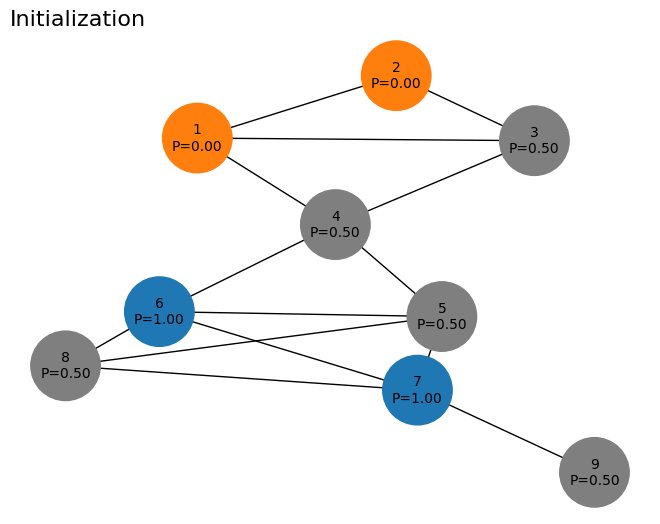

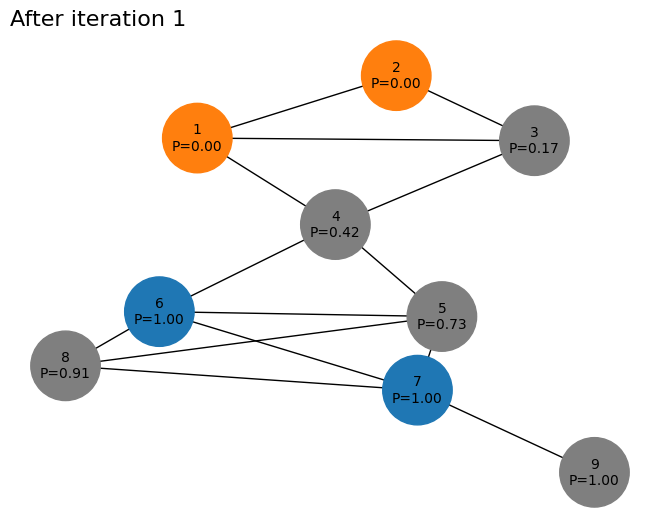

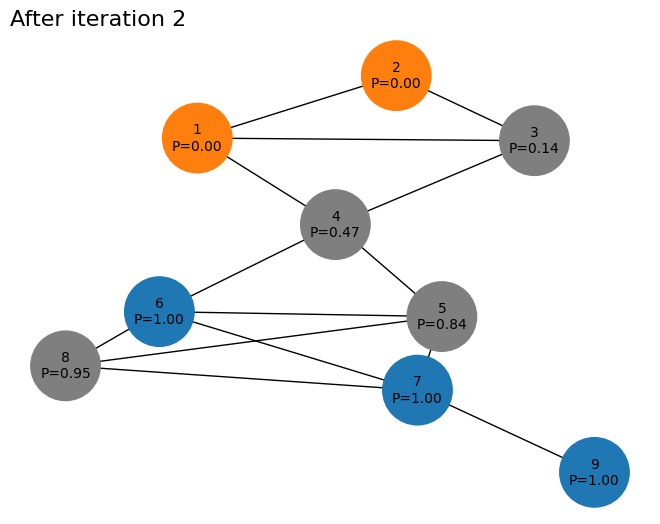

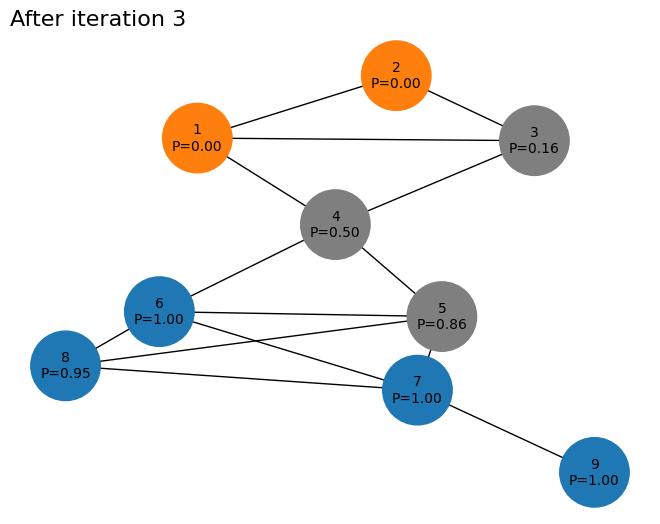

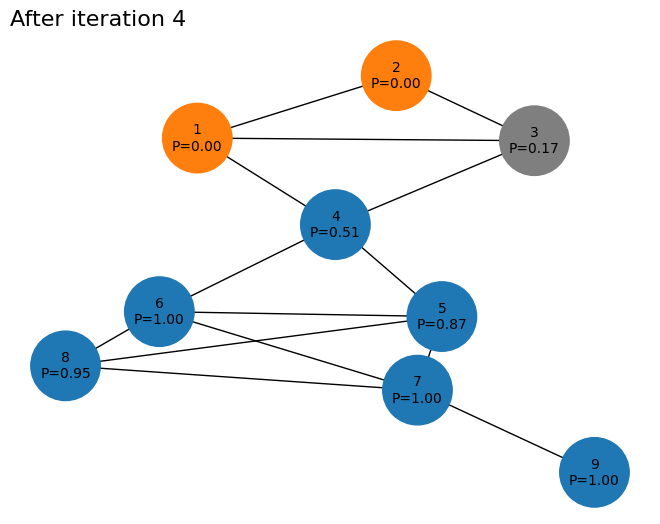

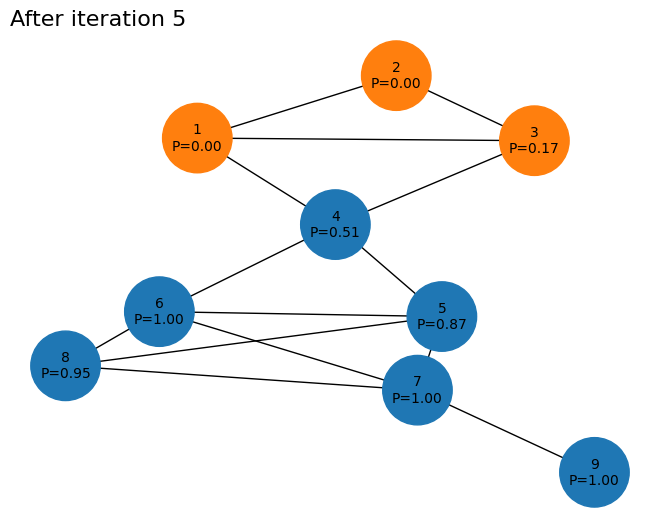

In [9]:
edge_list = [
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 3),
    (3, 4),
    (4, 5),
    (4, 6),
    (5, 6),
    (5, 7),
    (5, 8),
    (6, 7),
    (6, 8),
    (7, 8),
    (7, 9),
]

G = nx.Graph(edge_list)
attrs = {
    1: {"label": 0},
    2: {"label": 0},
    3: {"label": None},
    4: {"label": None},
    5: {"label": None},
    6: {"label": 1},
    7: {"label": 1},
    8: {"label": None},
    9: {"label": None},
}

nx.set_node_attributes(G, attrs)
clf = ProbabilisticRelationalClassifier()
clf.predict(G)

In [15]:
# IterativeClassifier
class IterativeClassifier:
    def __init__(
        self,
        max_iter: int = 10,
        edge_width: float = 2.0,
        node_size: int = 5000,
        node_edge_widths: int = 4,
        node_font_size: int = 8,
        title_font_size: int = 16,
        fig_size: Optional[Tuple[int, int]] = None,
        seed: Optional[int] = 42,
    ) -> None:
        self.max_iter = max_iter
        self.edge_width = edge_width
        self.node_size = node_size
        self.node_edge_widths = node_edge_widths
        self.node_font_size = node_font_size
        self.title_font_size = title_font_size
        self.fig_size = fig_size
        self.seed = seed

    @staticmethod
    def phi1(fv: np.ndarray) -> int:
        return int(fv[0] == 0)  #int of boolean is 1 or 0

    @staticmethod
    def phi2(fv: np.ndarray, zv: np.ndarray) -> int:
        return 1 if fv[0] == 0 or zv[:, 1].sum() > 1 else 0

    def _apply_classifier_to_unlabeled_set(self) -> None:
        for node in self._G.nodes(data=True):
            node[1]["Yv"] = self.phi1(node[1]["fv"]) if node[1]["Yv"] is None else node[1]["Yv"]

    def _update_relational_features(self) -> None:
        for node in self._G.nodes():
            zv = np.zeros((2, 2), dtype=int)

            for predecessor in self._G.predecessors(node):
                Yv = self._G.nodes[predecessor]["Yv"]
                if Yv is not None:
                    zv[0, Yv] += 1

            for successor in self._G.successors(node):
                Yv = self._G.nodes[successor]["Yv"]
                if Yv is not None:
                    zv[1, Yv] += 1

            self._G.nodes[node]["zv"] = zv

    def _update_labels(self) -> None:
        for node in self._G.nodes(data=True):
            node[1]["Yv"] = self.phi2(node[1]["fv"], node[1]["zv"])

    def _iteration(self) -> bool:
        self._update_relational_features()
        old_Yv = nx.get_node_attributes(self._G, "Yv")
        self._update_labels()
        return old_Yv == nx.get_node_attributes(self._G, "Yv")

    def _draw(self) -> None:
        node_colors = [
            "tab:gray" if node[1]["Yv"] is None else "tab:blue" if node[1]["Yv"] else "tab:orange"
            for node in self._G.nodes(data=True)
        ]
        node_edge_colors = ["tab:blue" if node[1]["gt"] else "tab:orange" for node in self._G.nodes(data=True)]
        label = "Gt: {}, Yv: {}\nfv {}\nI {}\nO {}"
        node_lables = {
            node[0]: label.format(node[1]["gt"], node[1]["Yv"], node[1]["fv"], node[1]["zv"][0], node[1]["zv"][1])
            for node in self._G.nodes(data=True)
        }
        pos = nx.spring_layout(self._G, k=1.0, seed=self.seed)
        nx.draw(
            self._G,
            pos=pos,
            width=self.edge_width,
            node_color=node_colors,
            edgecolors=node_edge_colors,
            linewidths=self.node_edge_widths,
            labels=node_lables,
            node_size=self.node_size,
            font_size=self.node_font_size,
            with_labels=True,
        )

    def predict(self, G: nx.Graph, display: bool = True) -> nx.Graph:
        self._G = G.copy()
        self._update_relational_features()
        self._apply_classifier_to_unlabeled_set()
        num_iter = 0
        if display:
            plt.figure(figsize=self.fig_size)
            self._draw()
            plt.title("Apply classifier to unlabeled set", fontsize=self.title_font_size, loc="left")
            plt.show()

        is_converged = False
        while not is_converged and num_iter < self.max_iter:
            is_converged = self._iteration()
            num_iter += 1
            if display:
                plt.figure(figsize=self.fig_size)
                self._draw()
                plt.title(f"After iteration {num_iter}", fontsize=self.title_font_size, loc="left")
                plt.show()

        return self._G









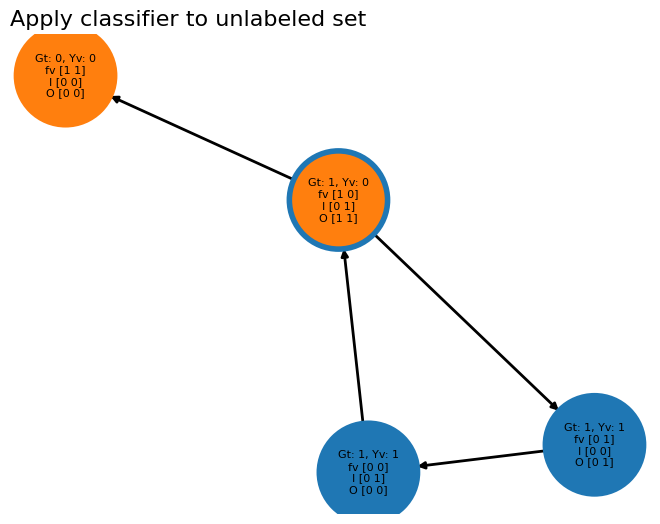

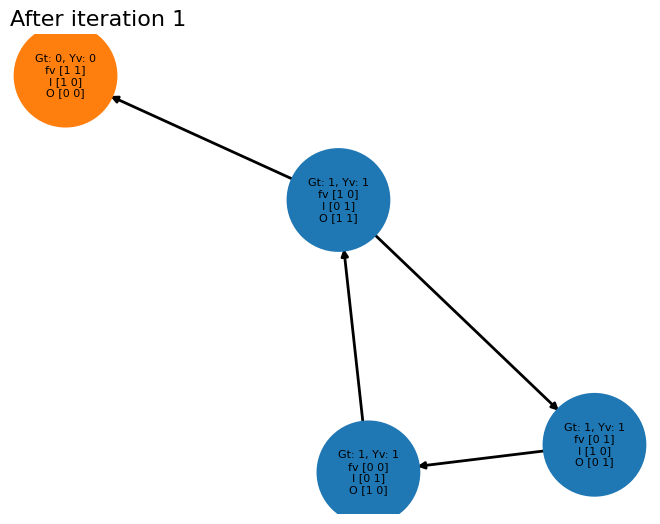

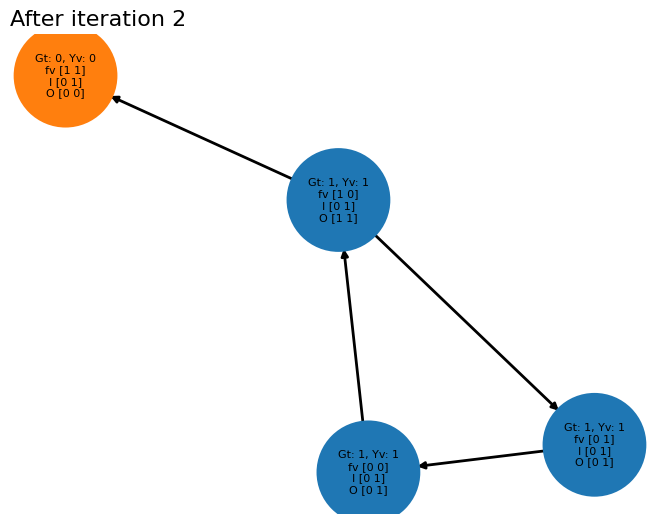

In [16]:
edge_list = [(1, 2), (2, 3), (3, 1), (3, 4)]
G = nx.DiGraph(edge_list)
attrs = {
    1: {"fv": np.array([0, 1]), "Yv": 1, "gt": 1},
    2: {"fv": np.array([0, 0]), "Yv": 1, "gt": 1},
    3: {"fv": np.array([1, 0]), "Yv": None, "gt": 1},
    4: {"fv": np.array([1, 1]), "Yv": 0, "gt": 0},
}
nx.set_node_attributes(G, attrs)
clf = IterativeClassifier()
clf.predict(G)

In [10]:
#correct and smooth method
def get_normalized_diffusion_matrix(G: nx.Graph) -> np.ndarray:
    A = np.asarray(nx.adjacency_matrix(G).todense())
    degrees = np.array([degree for _, degree in G.degree()])
    # Add self-loops
    A[range(len(A)), range(len(A))] = 1.0
    degrees += 1
    # Compute D^-1/2
    Dm12 = np.diag(1 / np.sqrt(degrees))
    return Dm12.dot(A).dot(Dm12)

class CorrectAndSmooth:
  def __init__(self, correct_alpha=0.8, smooth_alpha=0.8, smooth_s=2.0,
               num_correct_iters=3, num_smooth_iters=3, edge_width=2.0,
               node_size=2500, node_edge_widths=4, node_font_size=12,
               title_font_size=16, fig_size=None, seed=42):
    self.correct_alpha = correct_alpha
    self.smooth_alpha = smooth_alpha
    self.smooth_s = smooth_s
    self.num_correct_iters = num_correct_iters
    self.num_smooth_iters = num_smooth_iters
    self.edge_width = edge_width
    self.node_size = node_size
    self.node_edge_widths = node_edge_widths
    self.node_font_size = node_font_size
    self.title_font_size = title_font_size
    self.fig_size = fig_size
    self.seed = seed

  def _correct_step(self):
    E = self._compute_train_errs()
    for _ in range(self.num_correct_iters):
      E = self._diffuse(E, self.correct_alpha)

    for idx, (_, attrs) in enumerate(self._G.nodes(data=True)):
      attrs["soft_label"] += self.smooth_s * E[idx]

  def _smooth_step(self):
    Z = self._get_labels()
    for _ in range(self.num_smooth_iters):
      Z = self._diffuse(Z, self.smooth_alpha)

    for idx, (_, attrs) in enumerate(self._G.nodes(data=True)):
      attrs["soft_label"] = Z[idx]  #assign diffusion score to soft_label feature

  def _compute_train_errs(self):
    E = np.zeros((self._G.number_of_nodes(), 2))
    for idx, (_, attrs) in enumerate(self._G.nodes(data=True)):
      gt = attrs["ground_truth"]
      if gt is not None:
        E[idx] = gt - attrs["soft_label"]
    return E

  def _get_labels(self):
    Z = np.zeros((self._G.number_of_nodes(), 2))
    for idx, (_, attrs) in enumerate(self._G.nodes(data=True)):
      gt = attrs["ground_truth"]
      if gt is None:
        Z[idx] = attrs["soft_label"]  #use soft label where gt is none
      else:
        Z[idx] = gt
    return Z

  def _diffuse(self, X, alpha):
    return (1 - alpha) * X + alpha * self._A_tilde.dot(X)

  def _draw(self):
    node_colors = [
        "tab:orange" if np.argmax(node[1]["soft_label"]) else "tab:blue" for node in self._G.nodes(data=True)
    ]
    node_labels = {
        node[0]: f"[{node[0]}]\n{node[1]['soft_label'][0]:.2f}\n{node[1]['soft_label'][1]:.2f}" for node in self._G.nodes(data=True)
    }
    pos = nx.spring_layout(self._G, seed=self.seed)
    nx.draw(self._G, pos=pos, width=self.edge_width, node_color=node_colors, linewidths=self.node_edge_widths,
            labels=node_labels, node_size=self.node_size, font_size=self.node_font_size, with_labels=True)

  def predict(self, G, display=True):
    self._G = G.copy()
    if display:
      plt.figure(figsize=self.fig_size)
      self._draw()
      plt.title("Initial soft labels", fontsize=self.title_font_size, loc="left")
      plt.show()

    self._A_tilde = get_normalized_diffusion_matrix(self._G)
    self._correct_step()
    if display:
      plt.figure(figsize=self.fig_size)
      self._draw()
      plt.title("After correct step", fontsize=self.title_font_size, loc="left")
      plt.show()

    self._smooth_step()
    if display:
      plt.figure(figsize=self.fig_size)
      self._draw()
      plt.title("After smooth step", fontsize=self.title_font_size, loc="left")
      plt.show()

    return self._G




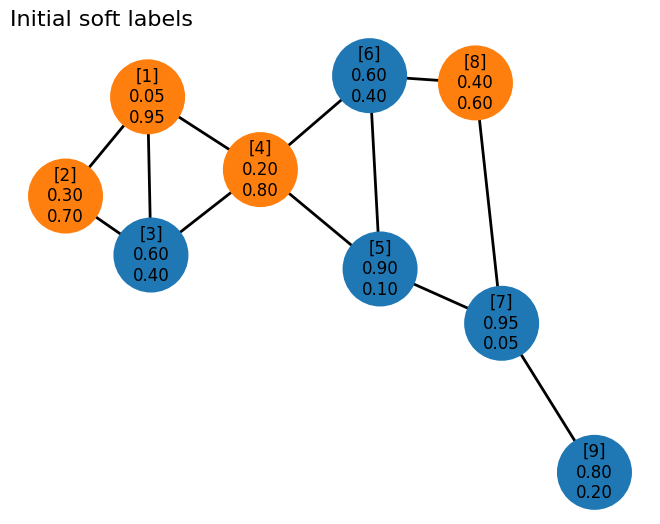

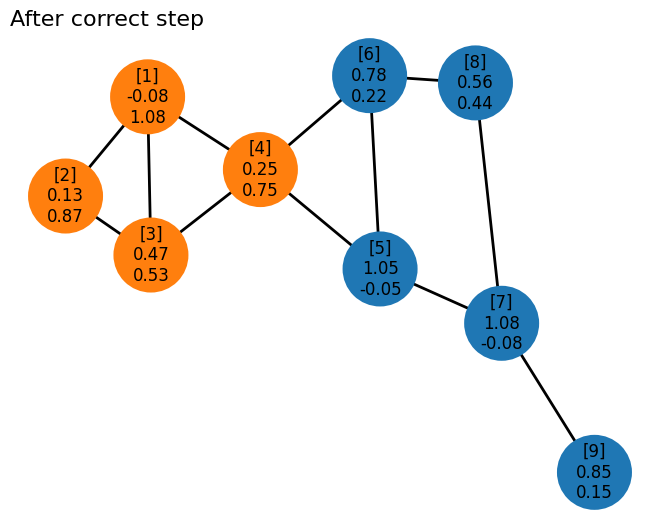

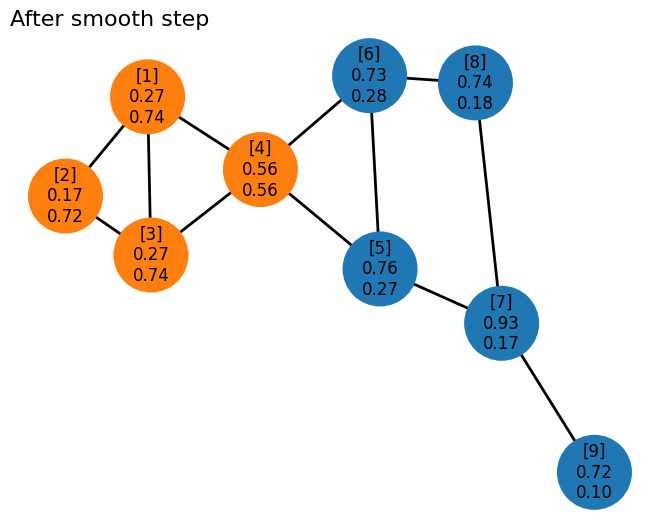

In [11]:
edge_list = [
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 3),
    (3, 4),
    (4, 5),
    (4, 6),
    (5, 6),
    (5, 7),
    (6, 8),
    (7, 8),
    (7, 9),
]

G = nx.Graph(edge_list)
attrs = {
    1: {"soft_label": np.array([0.05, 0.95]), "ground_truth": np.array([0.0, 1.0])},
    2: {"soft_label": np.array([0.30, 0.70]), "ground_truth": np.array([0.0, 1.0])},
    3: {"soft_label": np.array([0.60, 0.40]), "ground_truth": None},
    4: {"soft_label": np.array([0.20, 0.80]), "ground_truth": None},
    5: {"soft_label": np.array([0.90, 0.10]), "ground_truth": None},
    6: {"soft_label": np.array([0.60, 0.40]), "ground_truth": np.array([1.0, 0.0])},
    7: {"soft_label": np.array([0.95, 0.05]), "ground_truth": np.array([1.0, 0.0])},
    8: {"soft_label": np.array([0.40, 0.60]), "ground_truth": None},
    9: {"soft_label": np.array([0.80, 0.20]), "ground_truth": None},
}
nx.set_node_attributes(G, attrs)
clf = CorrectAndSmooth()
clf.predict(G)